In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directories
me_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge')
me_baseline_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge_baseline')

all_results_dir = Path(cfg.results_dirs['survival'], 'all_shuffle_cancer_type')
all_baseline_results_dir = Path(cfg.results_dirs['survival'], 'all_shuffle_cancer_type')

# set list of PCA component numbers to look for
pcs_list = [10, 100]

### Count results files, expression vs. methylation

In [3]:
# get baseline predictor results, using non-omics covariates only
me_all_results_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    try:
        me_pcs_dir = Path(me_results_dir, 'results_{}_pca'.format(n_dim))
        me_results_df = su.load_survival_results(me_pcs_dir)
        me_results_df.rename(columns={'identifier': 'cancer_type',
                                      'fold_no': 'fold'}, inplace=True)
        me_results_df['n_dim'] = n_dim
        me_all_results_df.append(me_results_df)
    except FileNotFoundError:
        # just skip if certain dimension didn't run
        continue
    
me_all_results_df = pd.concat(me_all_results_df)
me_all_results_df = me_all_results_df.reset_index(drop=True)

print(me_all_results_df.shape)
print(me_all_results_df.n_dim.unique())
print(me_all_results_df.training_data.unique())
me_all_results_df.head()

(5664, 8)
[ 10 100]
['expression' 'me_450k' 'me_27k']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.97443,train,PCPG,expression,signal,1,0,10
1,0.97443,cv,PCPG,expression,signal,1,0,10
2,0.22137,test,PCPG,expression,signal,1,0,10
3,0.88533,train,PCPG,expression,signal,1,1,10
4,0.88533,cv,PCPG,expression,signal,1,1,10


In [4]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (me_all_results_df
    .groupby(['cancer_type', 'training_data', 'n_dim', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,n_dim,signal,results_count
0,ACC,expression,10,shuffled,24
1,ACC,expression,10,signal,24
2,ACC,expression,100,shuffled,12
3,ACC,expression,100,signal,24
4,ACC,me_27k,10,shuffled,24
5,ACC,me_27k,10,signal,24
6,ACC,me_27k,100,signal,24
7,ACC,me_450k,10,shuffled,24
8,ACC,me_450k,10,signal,24
9,ACC,me_450k,100,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, 10 dims, shuffled')

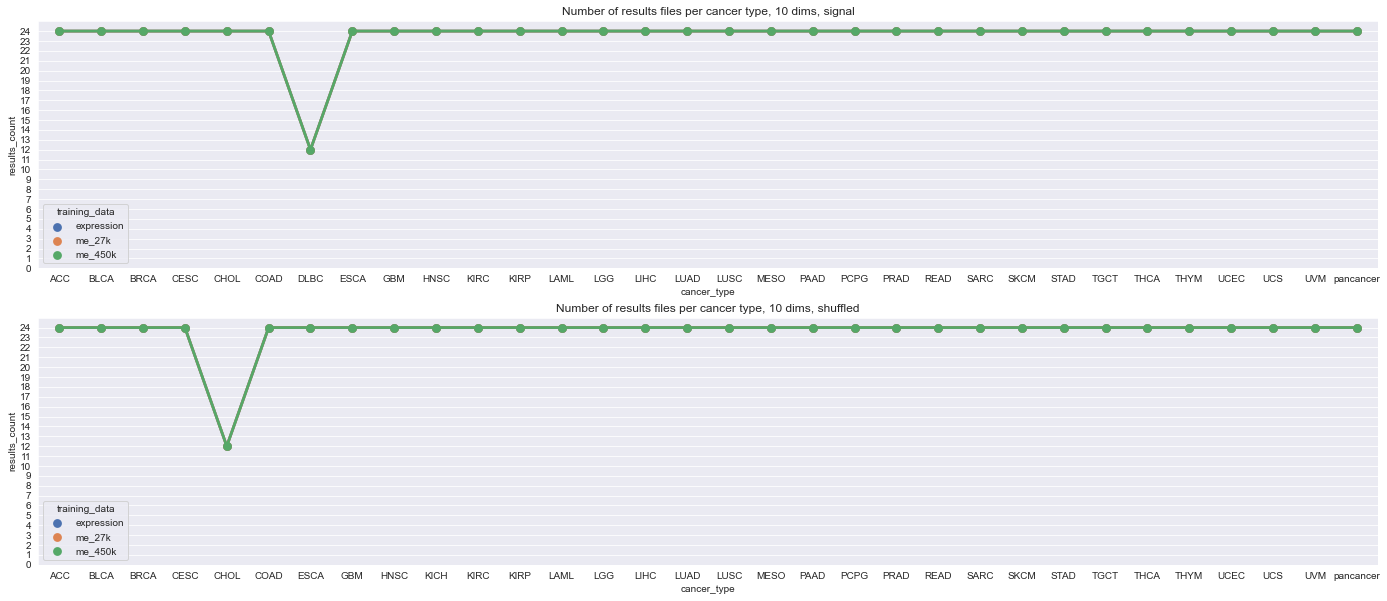

In [5]:
n_dim = 10

sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, {} dims, signal'.format(n_dim))

sns.pointplot(data=count_df[(count_df.signal == 'shuffled') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, {} dims, shuffled'.format(n_dim))

### Identify failed model fits, expression vs. methylation

In [7]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
me_all_results_df['failed_fit'] = (me_all_results_df.cindex == 0.5)
print(me_all_results_df.failed_fit.sum())
me_all_results_df.head()

16


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim,failed_fit
0,0.97443,train,PCPG,expression,signal,1,0,10,False
1,0.97443,cv,PCPG,expression,signal,1,0,10,False
2,0.22137,test,PCPG,expression,signal,1,0,10,False
3,0.88533,train,PCPG,expression,signal,1,1,10,False
4,0.88533,cv,PCPG,expression,signal,1,1,10,False


In [8]:
failed_summary_df = (me_all_results_df
    .loc[(me_all_results_df.data_type == 'test') & (me_all_results_df.signal == 'signal'), :]
    .groupby(['cancer_type', 'n_dim'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,n_dim,failed_fit
0,ACC,10,0
1,ACC,100,0
2,BLCA,10,0
3,BLCA,100,0
4,BRCA,10,0


Text(0.5, 1.0, 'Number of failed fits per cancer type')

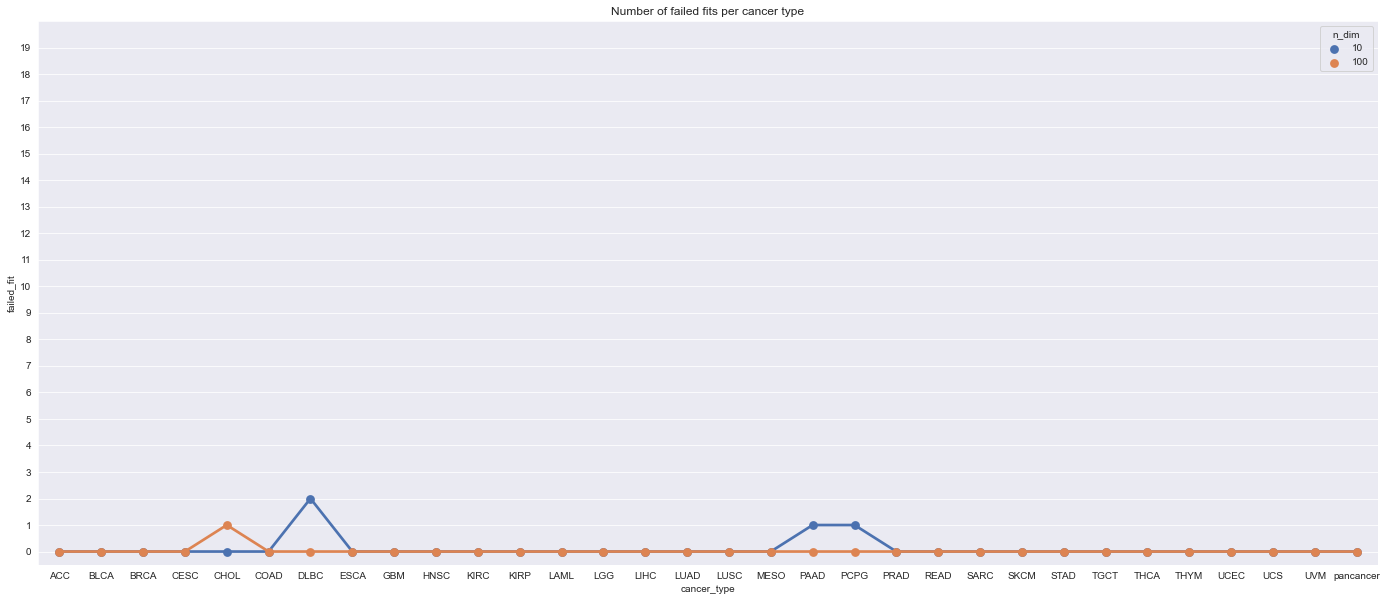

In [9]:
sns.set({'figure.figsize': (24, 10)})
sns.pointplot(data=failed_summary_df, x='cancer_type', y='failed_fit', hue='n_dim')
plt.ylim(-0.5, 20)
plt.yticks(range(0, 20))
plt.title('Number of failed fits per cancer type')

### Count results files, expression vs. methylation baseline

In [11]:
# get baseline predictor results, using non-omics covariates only
me_baseline_results_df = su.load_survival_results(me_baseline_results_dir)
me_baseline_results_df.rename(columns={'identifier': 'cancer_type',
                                       'fold_no': 'fold'}, inplace=True)

print(me_baseline_results_df.shape)
print(me_baseline_results_df.training_data.unique())
me_baseline_results_df.head()

(1512, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58652,train,THCA,baseline,shuffled,42,0
1,0.58652,cv,THCA,baseline,shuffled,42,0
2,0.62935,test,THCA,baseline,shuffled,42,0
3,0.51779,train,THCA,baseline,shuffled,42,1
4,0.51779,cv,THCA,baseline,shuffled,42,1


In [13]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (me_baseline_results_df
    .groupby(['cancer_type', 'training_data', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,signal,results_count
0,ACC,baseline,shuffled,24
1,ACC,baseline,signal,24
2,BLCA,baseline,shuffled,24
3,BLCA,baseline,signal,24
4,BRCA,baseline,shuffled,24
5,BRCA,baseline,signal,24
6,CESC,baseline,shuffled,24
7,CESC,baseline,signal,24
8,CHOL,baseline,shuffled,12
9,CHOL,baseline,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, baseline, shuffled')

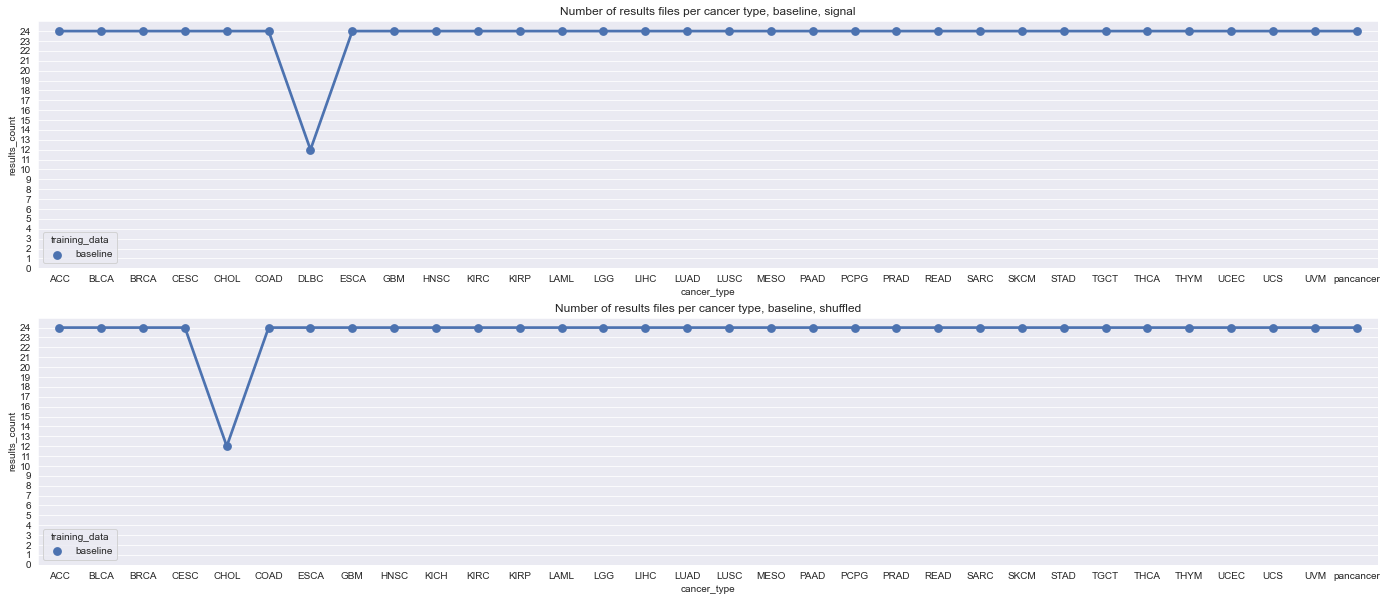

In [14]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, baseline, signal')

sns.pointplot(data=count_df[(count_df.signal == 'shuffled')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, baseline, shuffled')

### Identify failed model fits, expression vs. methylation, baseline

In [15]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
me_baseline_results_df['failed_fit'] = (me_baseline_results_df.cindex == 0.5)
print(me_baseline_results_df.failed_fit.sum())
me_baseline_results_df.head()

5


,cindex,data_type,cancer_type,training_data,signal,seed,fold,failed_fit
0,0.58652,train,THCA,baseline,shuffled,42,0,False
1,0.58652,cv,THCA,baseline,shuffled,42,0,False
2,0.62935,test,THCA,baseline,shuffled,42,0,False
3,0.51779,train,THCA,baseline,shuffled,42,1,False
4,0.51779,cv,THCA,baseline,shuffled,42,1,False


In [19]:
failed_summary_df = (me_baseline_results_df
    .loc[(me_baseline_results_df.data_type == 'test')]
    .groupby(['cancer_type', 'signal'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,signal,failed_fit
0,ACC,shuffled,0
1,ACC,signal,0
2,BLCA,shuffled,0
3,BLCA,signal,0
4,BRCA,shuffled,0


Text(0.5, 1.0, 'Number of failed fits per cancer type, baseline, shuffled')

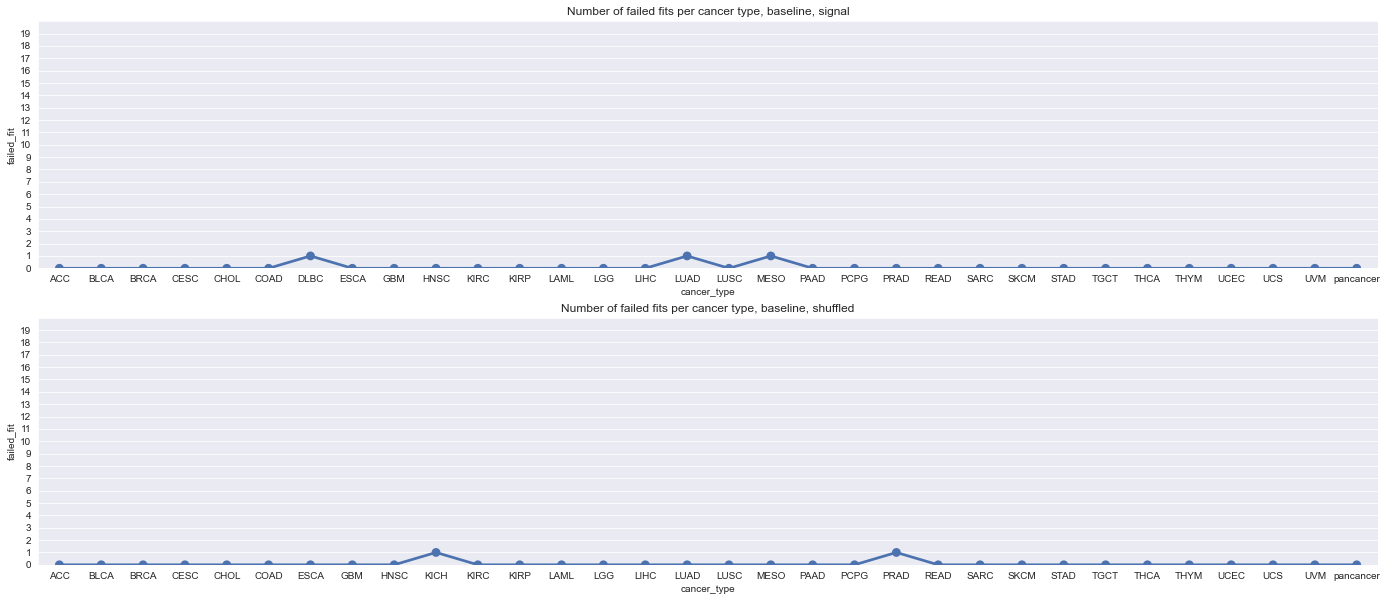

In [20]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'signal'],
              x='cancer_type', y='failed_fit', ax=axarr[0])
axarr[0].set_ylim(0, 20)
axarr[0].set_yticks(range(0, 20))
axarr[0].set_title('Number of failed fits per cancer type, baseline, signal')

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'shuffled'],
              x='cancer_type', y='failed_fit', ax=axarr[1])
axarr[1].set_ylim(0, 20)
axarr[1].set_yticks(range(0, 20))
axarr[1].set_title('Number of failed fits per cancer type, baseline, shuffled')